In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import bisect

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
indexData = pd.read_csv('../data/indexData_gov2sorted_uint16.txt', sep='\t', header=None)

In [3]:
header = ['Term', 'Li_Len', '1s_Qnt', '1rl_Avg', 'Liwo1_Len', 'C_Li_Len', 'C_Liwo1_Len', 'Bitmap_Bytes',
          'Bitmap_BytesOnDisk', 'EWAH_bitmap_Bytes', 'EWAH_bitmap_BytesOnDisk', 'Bitmap_1s']
indexData.columns = header

In [4]:
#indexData['Bitmap_Bytes'] = indexData.Li_Len / 8 + 1
indexData['Li_Bytes'] = indexData.Li_Len * 4
indexData['Liwo1_Bytes'] = indexData.Liwo1_Len * 4
indexData['C_Li_Bytes'] = indexData.C_Li_Len * 4
indexData['C_Liwo1_Bytes'] = indexData.C_Liwo1_Len * 4
indexData['Ones_Ratio'] = indexData['1s_Qnt'] / indexData.Li_Len

# SS_Ratio (Space Saving): 1 - (CompressedSize / UncompressedSize) #
indexData['SS_Ratio_Li'] = 1 - (indexData.C_Li_Bytes / indexData.Li_Bytes)
indexData['SS_Ratio_Liwo1'] = 1 - (indexData.C_Liwo1_Bytes / indexData.Liwo1_Bytes)

indexData['SS_Ratio_Hybrid_Un'] = 1 - (indexData.Liwo1_Bytes + indexData.Bitmap_Bytes) / indexData.Li_Bytes
indexData['SS_Ratio_Hybrid_Co'] = 1 - (indexData.C_Liwo1_Bytes + indexData.EWAH_bitmap_Bytes) / indexData.Li_Bytes

indexData['SS_Ratio_Hybrid_Un_woBitmap'] = 1 - (indexData.Liwo1_Bytes) / indexData.Li_Bytes
indexData['SS_Ratio_Hybrid_Co_woBitmap'] = 1 - (indexData.C_Liwo1_Bytes) / indexData.Li_Bytes

indexData['C_Li_wo1_EWAH_bitmap_Bytes'] = indexData.C_Liwo1_Bytes + indexData.EWAH_bitmap_Bytes


In [5]:
indexData[indexData.columns[1:]]
#indexData[['SS_Ratio_Li', 'SS_Ratio_Liwo1', 'SS_Ratio_Hybrid_Un', 'SS_Ratio_Hybrid_Co']]

,Li_Len,1s_Qnt,1rl_Avg,Liwo1_Len,C_Li_Len,C_Liwo1_Len,Bitmap_Bytes,Bitmap_BytesOnDisk,EWAH_bitmap_Bytes,EWAH_bitmap_BytesOnDisk,...,C_Li_Bytes,C_Liwo1_Bytes,Ones_Ratio,SS_Ratio_Li,SS_Ratio_Liwo1,SS_Ratio_Hybrid_Un,SS_Ratio_Hybrid_Co,SS_Ratio_Hybrid_Un_woBitmap,SS_Ratio_Hybrid_Co_woBitmap,C_Li_wo1_EWAH_bitmap_Bytes
0,13059642,11398025,13.698,1661617,812043,220362,1424754,1424762,5590,5606,...,3248172,881448,0.873,0.938,0.867,0.845,0.983,0.873,0.983,887038
1,12060760,11120312,28.084,940448,645364,144277,1390040,1390048,5454,5470,...,2581456,577108,0.922,0.946,0.847,0.893,0.988,0.922,0.988,582562
2,11066901,9619645,15.573,1447256,683745,207344,1202456,1202464,4718,4734,...,2734980,829376,0.869,0.938,0.857,0.842,0.981,0.869,0.981,834094
3,10789754,9097964,10.546,1691790,708524,220144,1137246,1137254,4462,4478,...,2834096,880576,0.843,0.934,0.870,0.817,0.979,0.843,0.980,885038
4,10286262,9290667,21.648,995595,605432,153331,1161334,1161342,4558,4574,...,2421728,613324,0.903,0.941,0.846,0.875,0.985,0.903,0.985,617882
5,10086692,9441816,35.850,644876,527377,109311,1180228,1180236,4632,4648,...,2109508,437244,0.936,0.948,0.830,0.907,0.989,0.936,0.989,441876
6,9606809,7912738,10.227,1694071,660517,232065,989094,989102,3882,3898,...,2642068,928260,0.824,0.931,0.863,0.798,0.976,0.824,0.976,932142
7,9440690,8428604,18.334,1012086,591425,164571,1053576,1053584,4134,4150,...,2365700,658284,0.893,0.937,0.837,0.865,0.982,0.893,0.983,662418
8,9093904,8306109,28.043,787795,508637,132789,1038264,1038272,4074,4090,...,2034548,531156,0.913,0.944,0.831,0.885,0.985,0.913,0.985,535230
9,8921736,7271160,9.579,1650576,626178,229042,908896,908904,3568,3584,...,2504712,916168,0.815,0.930,0.861,0.790,0.974,0.815,0.974,919736


In [6]:
# Size of vocabulary: 14813510 (terms) #
# 2134281 / 14813510 = 0.144076657 #
#indexData[indexData.columns[9:]].describe()
indexData.describe()

,Term,Li_Len,1s_Qnt,1rl_Avg,Liwo1_Len,C_Li_Len,C_Liwo1_Len,Bitmap_Bytes,Bitmap_BytesOnDisk,EWAH_bitmap_Bytes,...,C_Li_Bytes,C_Liwo1_Bytes,Ones_Ratio,SS_Ratio_Li,SS_Ratio_Liwo1,SS_Ratio_Hybrid_Un,SS_Ratio_Hybrid_Co,SS_Ratio_Hybrid_Un_woBitmap,SS_Ratio_Hybrid_Co_woBitmap,C_Li_wo1_EWAH_bitmap_Bytes
count,794518.000,794518.000,794518.000,794518.000,794518.000,794518.000,794518.000,794518.000,794518.000,794518.000,...,794518.000,794518.000,794518.000,794518.000,794518.000,794518.000,794518.000,794518.000,794518.000,794518.000
mean,531521.060,7437.489,4418.782,16.726,3018.707,1190.384,856.040,553.292,561.292,5.935,...,4761.536,3424.162,0.223,0.520,0.476,0.215,0.587,0.223,0.591,3430.096
std,367906.385,110959.931,86465.751,1264.280,29714.435,10298.647,5844.403,10808.218,10808.218,42.343,...,41194.587,23377.610,0.211,0.143,0.144,0.205,0.159,0.211,0.158,23407.625
min,0.000,100.000,1.000,1.000,1.000,27.000,2.000,2.000,10.000,2.000,...,108.000,8.000,0.000,0.182,-1.000,0.000,0.200,0.000,0.207,10.000
25%,198853.250,149.000,18.000,1.231,117.000,82.000,62.000,4.000,12.000,4.000,...,328.000,248.000,0.088,0.407,0.386,0.085,0.462,0.088,0.466,252.000
50%,398313.500,272.000,47.000,1.564,210.000,135.000,120.000,6.000,14.000,4.000,...,540.000,480.000,0.154,0.497,0.459,0.148,0.563,0.154,0.567,484.000
75%,905429.750,776.000,150.000,2.333,580.000,343.000,295.000,20.000,28.000,4.000,...,1372.000,1180.000,0.267,0.625,0.570,0.258,0.685,0.267,0.687,1184.000
max,1107204.000,13059642.000,11398025.000,550694.000,1941194.000,812043.000,277297.000,1424754.000,1424762.000,5590.000,...,3248172.000,1109188.000,1.000,0.965,0.924,0.969,1.000,1.000,1.000,1111402.000


In [7]:
bins = np.array((.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.), dtype=np.float64)
count_won_SS_Ratio_Hybrid_Co = np.zeros(10, dtype=np.float64)
count_lost_SS_Ratio_Hybrid_Co = np.zeros(10, dtype=np.float64)

#won_SS_SS_Ratio_Hybrid_Co = indexData[indexData['SS_Ratio_Hybrid_Co'] > indexData['SS_Ratio_Hybrid_Co']]['SS_Ratio_Hybrid_Co']
won_SS_Ratio_Hybrid_Co = np.array(indexData.query('SS_Ratio_Hybrid_Co > SS_Ratio_Li')['SS_Ratio_Hybrid_Co'])
lost_SS_Ratio_Hybrid_Co = np.array(indexData.query('SS_Ratio_Hybrid_Co <= SS_Ratio_Li')['SS_Ratio_Hybrid_Co'])

# Interval Type [) #
for SS_Ratio_Hybrid_Co in won_SS_Ratio_Hybrid_Co:
    count_won_SS_Ratio_Hybrid_Co[bisect.bisect_right(bins, SS_Ratio_Hybrid_Co)] += 1
for SS_Ratio_Hybrid_Co in lost_SS_Ratio_Hybrid_Co:
    # First interval includes NEGATIVE values #
    count_lost_SS_Ratio_Hybrid_Co[bisect.bisect_right(bins, SS_Ratio_Hybrid_Co)] += 1
    
# Slower! #
#for index, row in indexData.iterrows():
#    if (row.SS_Ratio_Hybrid_Co > row.SS_Ratio_Li):
#        count_won_SS_SS_Ratio_Hybrid_Co[bisect.bisect_right(bins, row.SS_Ratio_Hybrid_Co)] += 1
#    else: # row.SS_Ratio_Hybrid_Co <= row.SS_Ratio_Li] #
#        count_lost_SS_SS_Ratio_Hybrid_Co[bisect.bisect_right(bins, row.SS_Ratio_Hybrid_Co)] += 1

count_won_SS_Ratio_Hybrid_Co = (count_won_SS_Ratio_Hybrid_Co / indexData.shape[0]) * 100
count_lost_SS_Ratio_Hybrid_Co = (count_lost_SS_Ratio_Hybrid_Co / indexData.shape[0]) * 100

print 'Bin\t\tWon\t\tLost'
previousBin = 0.0
totalWon = 0.0
totalLost = 0.0
for won, lost, bi in zip(count_won_SS_Ratio_Hybrid_Co, count_lost_SS_Ratio_Hybrid_Co, bins):
    print '[%.1f, %.1f)\t%.2f\t\t%.2f' %(previousBin, bi, won, lost)
    previousBin = bi
    totalWon += won
    totalLost += lost
print 'Total\t\t%.2f\t\t%.2f' %(totalWon, totalLost)


Bin		Won		Lost
[0.0, 0.1)	0.00		0.00
[0.1, 0.2)	0.00		0.00
[0.2, 0.3)	0.10		0.13
[0.3, 0.4)	8.10		1.39
[0.4, 0.5)	23.12		2.17
[0.5, 0.6)	21.52		1.00
[0.6, 0.7)	18.95		1.06
[0.7, 0.8)	10.84		0.35
[0.8, 0.9)	6.13		0.03
[0.9, 1.0)	5.11		0.00
Total		93.86		6.14


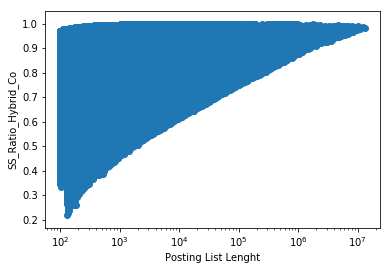

In [8]:
# SS_Ratio_Li / SS_Ratio_Hybrid_Co #

won_SS_Ratio_Hybrid_Co_dataFrame = indexData.query('SS_Ratio_Hybrid_Co > SS_Ratio_Li')[['Li_Len','SS_Ratio_Hybrid_Co']]
figure, ax = plt.subplots()
ax.scatter(won_SS_Ratio_Hybrid_Co_dataFrame.Li_Len, won_SS_Ratio_Hybrid_Co_dataFrame.SS_Ratio_Hybrid_Co)

ax.set_xlabel('Posting List Lenght')
ax.set_ylabel('SS_Ratio_Hybrid_Co')
ax.set_xscale('log')
#ax.set_yscale('log')

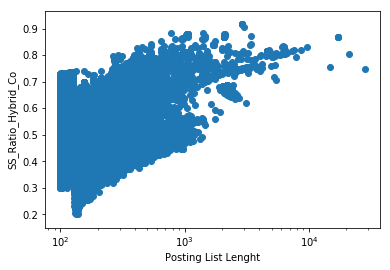

In [9]:
# SS_Ratio_Li / SS_Ratio_Hybrid_Co #

lost_SS_Ratio_Hybrid_Co_dataFrame = indexData.query('SS_Ratio_Hybrid_Co <= SS_Ratio_Li')[['Li_Len','SS_Ratio_Hybrid_Co']]
figure, ax = plt.subplots()
ax.scatter(lost_SS_Ratio_Hybrid_Co_dataFrame.Li_Len, lost_SS_Ratio_Hybrid_Co_dataFrame.SS_Ratio_Hybrid_Co)

ax.set_xlabel('Posting List Lenght')
ax.set_ylabel('SS_Ratio_Hybrid_Co')
ax.set_xscale('log')
#ax.set_yscale('log')

In [31]:
won_Hybrid_Co = indexData.query('SS_Ratio_Hybrid_Co > SS_Ratio_Li')
lost_Hybrid_Co = indexData.query('SS_Ratio_Hybrid_Co <= SS_Ratio_Li')

print 'Posting List Lenght (Li_Bytes)'
print '\tAverage\t\tStd\t\tMin\t\tMax'
print 'Won\t%.2f\t%.2f\t%i\t\t%i' %(won_Hybrid_Co.Li_Bytes.mean(), won_Hybrid_Co.Li_Bytes.std(),
                                    won_Hybrid_Co.Li_Bytes.min(), won_Hybrid_Co.Li_Bytes.max())
print 'Lost\t%.2f\t\t%.2f\t\t%i\t\t%i' %(lost_Hybrid_Co.Li_Bytes.mean(), lost_Hybrid_Co.Li_Bytes.std(),
                                         lost_Hybrid_Co.Li_Bytes.min(), lost_Hybrid_Co.Li_Bytes.max())

print ''
print 'Average 1\'s run Lenght (1rl_Avg)'
print '\tAverage\t\tStd\t\tMin\t\tMax'
print 'Won\t%.2f\t\t%.2f\t\t%.4f\t\t%.4f' %(won_Hybrid_Co['1rl_Avg'].mean(), won_Hybrid_Co['1rl_Avg'].std(),
                                            won_Hybrid_Co['1rl_Avg'].min(), won_Hybrid_Co['1rl_Avg'].max())
print 'Lost\t%.2f\t\t%.2f\t\t%.4f\t\t%.4f' %(lost_Hybrid_Co['1rl_Avg'].mean(), lost_Hybrid_Co['1rl_Avg'].std(),
                                             lost_Hybrid_Co['1rl_Avg'].min(), lost_Hybrid_Co['1rl_Avg'].max())

print ''
print '1\'s Ratio (Ones_Ratio)'
print '\tAverage\t\tStd\t\tMin\t\tMax'
print 'Won\t%.2f\t\t%.2f\t\t%.4f\t\t%.4f' %(won_Hybrid_Co['Ones_Ratio'].mean(), won_Hybrid_Co['Ones_Ratio'].std(),
                                            won_Hybrid_Co['Ones_Ratio'].min(), won_Hybrid_Co['Ones_Ratio'].max())
print 'Lost\t%.2f\t\t%.2f\t\t%.4f\t\t%.4f' %(lost_Hybrid_Co['Ones_Ratio'].mean(), lost_Hybrid_Co['Ones_Ratio'].std(),
                                             lost_Hybrid_Co['Ones_Ratio'].min(), lost_Hybrid_Co['Ones_Ratio'].max())

Posting List Lenght (Li_Bytes)
	Average		Std		Min		Max
Won	31613.05	458056.18	400		52238568
Lost	1251.86		2311.83		400		112004

Average 1's run Lenght (1rl_Avg)
	Average		Std		Min		Max
Won	17.74		1304.95		1.0000		550694.0000
Lost	1.21		0.46		1.0000		20.5000

1's Ratio (Ones_Ratio)
	Average		Std		Min		Max
Won	0.23		0.21		0.0005		1.0000
Lost	0.06		0.06		0.0000		0.4388


In [32]:
count_won_SS_Ratio_Hybrid_Un = np.zeros(10, dtype=np.float64)
#count_lost_SS_Ratio_Hybrid_Un = np.zeros(10, dtype=np.float64)

won_SS_Ratio_Hybrid_Un = np.array(indexData.query('SS_Ratio_Hybrid_Un > 0')['SS_Ratio_Hybrid_Un'])
#lost_SS_SS_Ratio_Hybrid_Un = np.array(indexData.query('SS_Ratio_Hybrid_Un <= 0')['SS_Ratio_Hybrid_Un'])

# Interval Type [) #
for SS_Ratio_Hybrid_Un in won_SS_Ratio_Hybrid_Un:
    count_won_SS_Ratio_Hybrid_Un[bisect.bisect_right(bins, SS_Ratio_Hybrid_Un)] += 1
#for SS_Ratio_Hybrid_Co in lost_SS_SS_Ratio_Hybrid_Un:
#    count_lost_SS_SS_Ratio_Hybrid_Co[bisect.bisect_right(bins, SS_Ratio_Hybrid_Co)] += 1

count_won_SS_Ratio_Hybrid_Un = (count_won_SS_Ratio_Hybrid_Un / indexData.shape[0]) * 100
#count_lost_SS_SS_Ratio_Hybrid_Co = (count_lost_SS_SS_Ratio_Hybrid_Co / indexData.shape[0]) * 100

print 'Bin\t\tWon'
previousBin = 0.0
totalWon = 0.0
for won, bi in zip(count_won_SS_Ratio_Hybrid_Un, bins):
    print '[%.1f, %.1f)\t%.2f' %(previousBin, bi, won)
    previousBin = bi
    totalWon += won
print 'Total\t\t%.2f' %(totalWon)



Bin		Won
[0.0, 0.1)	31.67
[0.1, 0.2)	32.92
[0.2, 0.3)	15.01
[0.3, 0.4)	6.83
[0.4, 0.5)	3.85
[0.5, 0.6)	2.36
[0.6, 0.7)	1.85
[0.7, 0.8)	1.76
[0.8, 0.9)	1.88
[0.9, 1.0)	1.87
Total		100.00


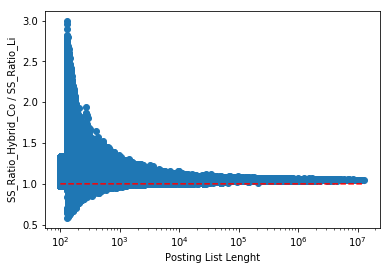

In [33]:
# SS_Ratio_Hybrid_Co / SS_Ratio_Li #

SS_Ratio_Hybrid_Co_over_SS_Ratio_Li = indexData.SS_Ratio_Hybrid_Co / indexData.SS_Ratio_Li

start = indexData.Li_Len.min()
stop = indexData.Li_Len.max()

s = np.arange(start, stop, 10, dtype=np.int64)
threshold = np.full((len(s)), 1.0, dtype=np.float64)

figure, ax = plt.subplots()
ax.plot(s, threshold, color='r', linestyle='--')
ax.scatter(indexData.Li_Len, SS_Ratio_Hybrid_Co_over_SS_Ratio_Li)

ax.set_xlabel('Posting List Lenght')
ax.set_ylabel('SS_Ratio_Hybrid_Co / SS_Ratio_Li')
ax.set_xscale('log')
#ax.set_yscale('log')

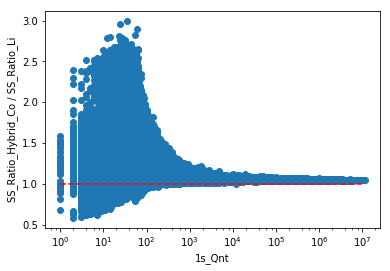

In [34]:
start = indexData['1s_Qnt'].min()
stop = indexData['1s_Qnt'].max()

s = np.arange(start, stop, 10, dtype=np.int64)
threshold = np.full((len(s)), 1.0, dtype=np.float64)

figure, ax = plt.subplots()
ax.plot(s, threshold, color='r', linestyle='--')
ax.scatter(indexData['1s_Qnt'], SS_Ratio_Hybrid_Co_over_SS_Ratio_Li)
ax.set_xlabel('1s_Qnt')
ax.set_ylabel('SS_Ratio_Hybrid_Co / SS_Ratio_Li')
ax.set_xscale('log')

(0.0, 1.1)

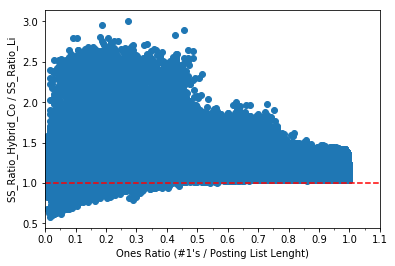

In [35]:
# How many ones do I need to win? #
# X-axis : One's proportion respect to Posting List Length #
# Y-axis : Hybrid Compression Ratio: HybridCompression / PForCompression #

start = 0.0
stop = 1.1

size = indexData.shape[0]

s = np.linspace(start, stop, size, dtype=np.float64)
threshold = np.full((len(s)), 1.0, dtype=np.float64)

figure, ax = plt.subplots()
ax.scatter(indexData.Ones_Ratio, SS_Ratio_Hybrid_Co_over_SS_Ratio_Li)
ax.plot(s, threshold, color='r', linestyle='--')
# Tickers #
min_x = MultipleLocator(0.05)
max_x = MultipleLocator(0.1)
ax.xaxis.set_major_locator(max_x)
ax.xaxis.set_minor_locator(min_x)
ax.set_xlabel('Ones Ratio (#1\'s / Posting List Lenght)')
ax.set_ylabel('SS_Ratio_Hybrid_Co / SS_Ratio_Li')
ax.set_xlim([0.0, 1.1])

In [10]:
# C_Li_Len vs C_Liwo1_Len 
C_Li_Len_vs_C_Liwo1_Len_count_greater = 0
C_Li_Len_vs_C_Liwo1_Len_count_less_equal = 0
assert (indexData.C_Li_Len.shape[0] == indexData.C_Liwo1_Len.shape[0]), "Error de tamaño"
for C_Li_Len, C_Liwo1_Len in zip(indexData.C_Li_Len.values, indexData.C_Liwo1_Len.values):
    if (C_Li_Len > C_Liwo1_Len):
        C_Li_Len_vs_C_Liwo1_Len_count_greater += 1
    else: #(C_Li_Len >= C_Liwo1_Len)
        C_Li_Len_vs_C_Liwo1_Len_count_less_equal += 1
    
print 'C_Li_Len > C_Liwo1_Len: %i out of %i (%.4f)' % (C_Li_Len_vs_C_Liwo1_Len_count_greater, indexData.C_Li_Len.shape[0], float(C_Li_Len_vs_C_Liwo1_Len_count_greater) / indexData.C_Li_Len.shape[0])
print 'C_Li_Len < C_Liwo1_Len: %i out of %i (%.4f)' % (C_Li_Len_vs_C_Liwo1_Len_count_less_equal, indexData.C_Li_Len.shape[0], float(C_Li_Len_vs_C_Liwo1_Len_count_less_equal) / indexData.C_Li_Len.shape[0])

C_Li_Len_vs_C_Liwo1_Len_greater = indexData.query('C_Li_Len > C_Liwo1_Len')['Li_Len']
C_Li_Len_vs_C_Liwo1_Len_less_equal = indexData.query('C_Li_Len <= C_Liwo1_Len')['Li_Len']

C_Li_Len > C_Liwo1_Len: 772504 out of 794518 (0.9723)
C_Li_Len < C_Liwo1_Len: 22014 out of 794518 (0.0277)


In [11]:
# Max Postings List Lenght: 13,059,642 #
# [0,10^3), [10^3,10^4), [10^4,10^5), [10^5,10^6), [10^6,10^7), [10^7,10^8) #
logBins = np.logspace(3.0, 8, num=6, dtype=np.uint64)
bin_count_C_Li_Len_vs_C_Liwo1_Len_greater = np.zeros(6, dtype=np.uint64)
bin_count_C_Li_Len_vs_C_Liwo1_Len_less_equal = np.zeros(6, dtype=np.uint64)
# Interval Type [) #
for Li_Len in C_Li_Len_vs_C_Liwo1_Len_greater.values:
    bin_count_C_Li_Len_vs_C_Liwo1_Len_greater[bisect.bisect_right(logBins, Li_Len)] += 1

for Li_Len in C_Li_Len_vs_C_Liwo1_Len_less_equal.values:
    bin_count_C_Li_Len_vs_C_Liwo1_Len_less_equal[bisect.bisect_right(logBins, Li_Len)] += 1
print bin_count_C_Li_Len_vs_C_Liwo1_Len_greater
print bin_count_C_Li_Len_vs_C_Liwo1_Len_less_equal

[606560 134284  24078   6476   1100      6]
[19447  2562     5     0     0     0]


[     1000     10000    100000   1000000  10000000 100000000]


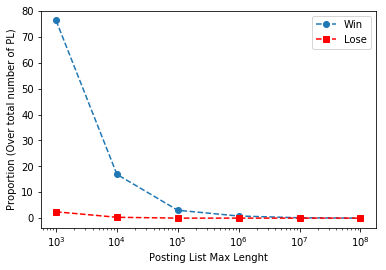

In [12]:
figure, ax = plt.subplots()
y = (bin_count_C_Li_Len_vs_C_Liwo1_Len_greater.astype(dtype=np.float64) / indexData.C_Li_Len.shape[0]) * 100
ax.plot(logBins, y, marker='o', linestyle='--', label='Win')
y = (bin_count_C_Li_Len_vs_C_Liwo1_Len_less_equal.astype(dtype=np.float64) / indexData.C_Li_Len.shape[0]) * 100
ax.plot(logBins, y, color='r', marker='s', linestyle='--', label='Lose')
ax.set_xlabel('Posting List Max Lenght')
ax.set_ylabel('Proportion (Over total number of PL)')
ax.set_xscale('log')
#x.set_yscale('log')
ax.legend()
print logBins


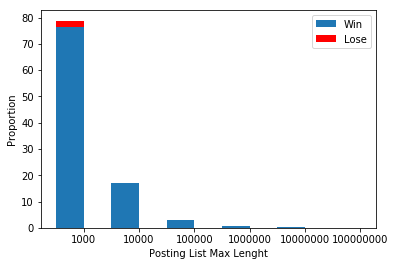

In [13]:
figure, ax = plt.subplots()
x = np.arange(6)

y1 = (bin_count_C_Li_Len_vs_C_Liwo1_Len_greater.astype(dtype=np.float64) / indexData.C_Li_Len.shape[0]) * 100
ax1 = ax.bar(x, y1, 0.50)

y2 = (bin_count_C_Li_Len_vs_C_Liwo1_Len_less_equal.astype(dtype=np.float64) / indexData.C_Li_Len.shape[0]) * 100
ax2 = ax.bar(x, y2, 0.50, bottom=y1, color='r')

plt.xticks(x + 0.5/2., map(lambda x: str(x), logBins))

ax.legend((ax1[0], ax2[0]), ('Win', 'Lose'))
ax.set_xlabel('Posting List Max Lenght')
ax.set_ylabel('Proportion')

[  96.89348522   98.12782252   99.97923847  100.          100.          100.        ]
[ 3.10651478  1.87217748  0.02076153  0.          0.          0.        ]


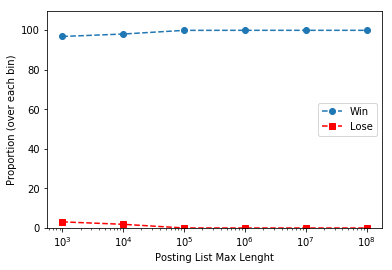

In [30]:
bin_absolute_proportion_C_Li_Len_vs_C_Liwo1_Len_greater = np.zeros(6, dtype=np.float64)
bin_absolute_proportion_C_Li_Len_vs_C_Liwo1_Len_less_equal = np.zeros(6, dtype=np.float64)

for i, (greater, less_equal) in enumerate(zip(bin_count_C_Li_Len_vs_C_Liwo1_Len_greater, bin_count_C_Li_Len_vs_C_Liwo1_Len_less_equal)):
    bin_absolute_proportion_C_Li_Len_vs_C_Liwo1_Len_greater[i] = (np.float64(greater) / (greater + less_equal)) * 100
    bin_absolute_proportion_C_Li_Len_vs_C_Liwo1_Len_less_equal[i] = (np.float64(less_equal) / (greater + less_equal)) * 100

print bin_absolute_proportion_C_Li_Len_vs_C_Liwo1_Len_greater
print bin_absolute_proportion_C_Li_Len_vs_C_Liwo1_Len_less_equal

figure, ax = plt.subplots()
ax.plot(logBins, bin_absolute_proportion_C_Li_Len_vs_C_Liwo1_Len_greater, marker='o', linestyle='--', label='Win')
ax.plot(logBins, bin_absolute_proportion_C_Li_Len_vs_C_Liwo1_Len_less_equal, color='r', marker='s', linestyle='--', label='Lose')
ax.set_xlabel('Posting List Max Lenght')
ax.set_ylabel('Proportion (over each bin)')
ax.set_xscale('log')
ax.set_ylim([0, 110])
#x.set_yscale('log')
ax.legend(loc=5)


In [15]:
# [0,10^3), [10^3,10^4), [10^4,10^5), [10^5,10^6), [10^6,10^7), [10^7,10^8) #
logBins = np.logspace(3.0, 8, num=6, dtype=np.uint64)
C_Li_wo1_EWAH_bitmap_Bytes_win = indexData.query('C_Li_wo1_EWAH_bitmap_Bytes < C_Li_Bytes')
C_Li_wo1_EWAH_bitmap_Bytes_lose = indexData.query('C_Li_wo1_EWAH_bitmap_Bytes >= C_Li_Bytes')

# Tamaño de la 'lista sin unos comprimida' para el enfoque híbrido
# Bins de acuerdo a Longitud de la Lista
bin_count_C_Li_wo1_EWAH_bitmap_Bytes_win = np.zeros(6, dtype=np.uint64)
bin_count_C_Li_wo1_EWAH_bitmap_Bytes_lose = np.zeros(6, dtype=np.uint64)

average_SS_Ratio_Hybrid_Co_bin_count_C_Li_wo1_EWAH_bitmap_Bytes_win = np.zeros(6, dtype=np.float64)
average_SS_Ratio_Hybrid_Co_bin_count_C_Li_wo1_EWAH_bitmap_Bytes_lose = np.zeros(6, dtype=np.float64)

average_Ones_Ratio_Hybrid_Co_bin_count_C_Li_wo1_EWAH_bitmap_Bytes_win = np.zeros(6, dtype=np.float64)
average_Ones_Ratio_Hybrid_Co_bin_count_C_Li_wo1_EWAH_bitmap_Bytes_lose = np.zeros(6, dtype=np.float64)

# Interval Type [) #
for row in C_Li_wo1_EWAH_bitmap_Bytes_win.values:
    Li_Len = row[1] # Longitud de la Lista (# de entradas)
    SS_Ratio_Hybrid_Co = row[20] # Space Saving Ratio
    Ones_Ratio = row[16] # Proporción de Unos
    index = bisect.bisect_right(logBins, Li_Len)
    bin_count_C_Li_wo1_EWAH_bitmap_Bytes_win[index] += 1 
    average_SS_Ratio_Hybrid_Co_bin_count_C_Li_wo1_EWAH_bitmap_Bytes_win[index] += SS_Ratio_Hybrid_Co
    average_Ones_Ratio_Hybrid_Co_bin_count_C_Li_wo1_EWAH_bitmap_Bytes_win[index] += Ones_Ratio

for row in C_Li_wo1_EWAH_bitmap_Bytes_lose.values:
    Li_Len = row[1]
    #SS_Ratio_Li = row[17]
    Ones_Ratio = row[16]
    SS_Ratio_Hybrid_Co = row[20]
    index = bisect.bisect_right(logBins, Li_Len)
    bin_count_C_Li_wo1_EWAH_bitmap_Bytes_lose[index] += 1
    average_SS_Ratio_Hybrid_Co_bin_count_C_Li_wo1_EWAH_bitmap_Bytes_lose[index] += SS_Ratio_Hybrid_Co
    average_Ones_Ratio_Hybrid_Co_bin_count_C_Li_wo1_EWAH_bitmap_Bytes_lose[index] += Ones_Ratio

print (bin_count_C_Li_wo1_EWAH_bitmap_Bytes_win.astype(dtype=np.float64) / indexData.C_Li_Len.shape[0]) * 100
print (bin_count_C_Li_wo1_EWAH_bitmap_Bytes_lose.astype(dtype=np.float64) / indexData.C_Li_Len.shape[0]) * 100

[  7.30502015e+01   1.68288195e+01   3.03026489e+00   8.15085373e-01
   1.38448720e-01   7.55174836e-04]
[  5.74058737e+00   3.94956439e-01   8.81037308e-04   0.00000000e+00
   0.00000000e+00   0.00000000e+00]


[  92.71413898   97.70691142   99.97093385  100.          100.          100.        ]
[ 7.28586102  2.29308858  0.02906615  0.          0.          0.        ]


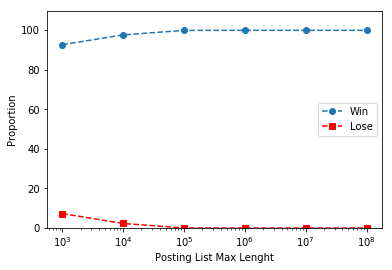

In [29]:
bin_absolute_proportion_C_Li_wo1_EWAH_bitmap_Bytes_win = np.zeros(6, dtype=np.float64)
bin_absolute_proportion_C_Li_wo1_EWAH_bitmap_Bytes_lose = np.zeros(6, dtype=np.float64)

for i, (more, less_equal) in enumerate(zip(bin_count_C_Li_wo1_EWAH_bitmap_Bytes_win, bin_count_C_Li_wo1_EWAH_bitmap_Bytes_lose)):
    bin_absolute_proportion_C_Li_wo1_EWAH_bitmap_Bytes_win[i] = (np.float64(more) / (more + less_equal)) * 100
    bin_absolute_proportion_C_Li_wo1_EWAH_bitmap_Bytes_lose[i] = (np.float64(less_equal) / (more + less_equal)) * 100

print bin_absolute_proportion_C_Li_wo1_EWAH_bitmap_Bytes_win
print bin_absolute_proportion_C_Li_wo1_EWAH_bitmap_Bytes_lose

# El eje de las ordenadas representa la proporcion (absoluta) de listas de acuerdo al criterio:
# Si C_Li_wo1_EWAH_bitmap_Bytes < C_Li_Bytes entonces 'win'
# Si C_Li_wo1_EWAH_bitmap_Bytes > C_Li_Bytes entonces 'lose'
figure, ax = plt.subplots()
ax.plot(logBins, bin_absolute_proportion_C_Li_wo1_EWAH_bitmap_Bytes_win, marker='o', linestyle='--', label='Win')
ax.plot(logBins, bin_absolute_proportion_C_Li_wo1_EWAH_bitmap_Bytes_lose, color='r', marker='s', linestyle='--', label='Lose')
ax.set_xlabel('Posting List Max Lenght')
ax.set_ylabel('Proportion')
ax.set_xscale('log')
ax.set_ylim([0, 110])
#x.set_yscale('log')
ax.legend(loc=5)

In [17]:
print average_SS_Ratio_Hybrid_Co_bin_count_C_Li_wo1_EWAH_bitmap_Bytes_lose
print bin_count_C_Li_wo1_EWAH_bitmap_Bytes_lose

print average_SS_Ratio_Hybrid_Co_bin_count_C_Li_wo1_EWAH_bitmap_Bytes_win
print bin_count_C_Li_wo1_EWAH_bitmap_Bytes_win

[  2.18614027e+04   2.16690879e+03   5.78504470e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
[45610  3138     7     0     0     0]
[  3.27591806e+05   8.90611526e+04   1.86682825e+04   5.66734038e+03
   1.03608552e+03   5.90562626e+00]
[580397 133708  24076   6476   1100      6]


In [18]:
average_SS_Ratio_Hybrid_Co_bin_count_C_Li_wo1_EWAH_bitmap_Bytes_win = average_SS_Ratio_Hybrid_Co_bin_count_C_Li_wo1_EWAH_bitmap_Bytes_win / bin_count_C_Li_wo1_EWAH_bitmap_Bytes_win
average_SS_Ratio_Hybrid_Co_bin_count_C_Li_wo1_EWAH_bitmap_Bytes_lose[:3] = average_SS_Ratio_Hybrid_Co_bin_count_C_Li_wo1_EWAH_bitmap_Bytes_lose[:3] / bin_count_C_Li_wo1_EWAH_bitmap_Bytes_lose[:3]

Win => C_Li_wo1_EWAH_bitmap_Bytes < C_Li_Bytes
Lose => C_Li_wo1_EWAH_bitmap_Bytes > C_Li_Bytes

Posting List Max Lenght		 SS_Ratio_Hybrid_Co_win		 SS_Ratio_Hybrid_Co_lose
1000 				 0.56 				 0.48
10000 				 0.67 				 0.69
100000 				 0.78 				 0.83
1000000 				 0.88 				 0.00
10000000 				 0.94 				 0.00
100000000 				 0.98 				 0.00


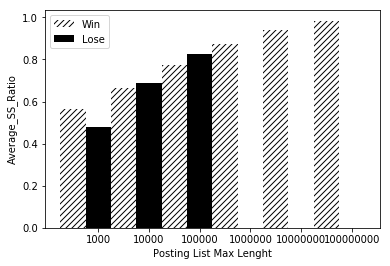

In [19]:
figure, ax = plt.subplots()
x = np.arange(6)

width = 0.5

ax.bar(x, average_SS_Ratio_Hybrid_Co_bin_count_C_Li_wo1_EWAH_bitmap_Bytes_win, width, color='w', hatch='////', label='Win')
ax.bar(x + width, average_SS_Ratio_Hybrid_Co_bin_count_C_Li_wo1_EWAH_bitmap_Bytes_lose, width , color='black', label='Lose')

plt.xticks(x + 0.5, map(lambda x: str(x), logBins))

ax.set_xlabel('Posting List Max Lenght')
ax.set_ylabel('Average_SS_Ratio')
ax.legend(loc=2)

print "Win => C_Li_wo1_EWAH_bitmap_Bytes < C_Li_Bytes"
print "Lose => C_Li_wo1_EWAH_bitmap_Bytes > C_Li_Bytes\n"
print "Posting List Max Lenght\t\t SS_Ratio_Hybrid_Co_win\t\t SS_Ratio_Hybrid_Co_lose"
for i, (win, lose) in enumerate(zip(average_SS_Ratio_Hybrid_Co_bin_count_C_Li_wo1_EWAH_bitmap_Bytes_win, average_SS_Ratio_Hybrid_Co_bin_count_C_Li_wo1_EWAH_bitmap_Bytes_lose)):
    print "%i \t\t\t\t %.2f \t\t\t\t %.2f" % (logBins[i], win, lose)

In [20]:
print average_Ones_Ratio_Hybrid_Co_bin_count_C_Li_wo1_EWAH_bitmap_Bytes_lose
print bin_count_C_Li_wo1_EWAH_bitmap_Bytes_lose

print average_Ones_Ratio_Hybrid_Co_bin_count_C_Li_wo1_EWAH_bitmap_Bytes_win
print bin_count_C_Li_wo1_EWAH_bitmap_Bytes_win

average_Ones_Ratio_Hybrid_Co_bin_count_C_Li_wo1_EWAH_bitmap_Bytes_win = average_Ones_Ratio_Hybrid_Co_bin_count_C_Li_wo1_EWAH_bitmap_Bytes_win / bin_count_C_Li_wo1_EWAH_bitmap_Bytes_win
average_Ones_Ratio_Hybrid_Co_bin_count_C_Li_wo1_EWAH_bitmap_Bytes_lose[:3] = average_Ones_Ratio_Hybrid_Co_bin_count_C_Li_wo1_EWAH_bitmap_Bytes_lose[:3] / bin_count_C_Li_wo1_EWAH_bitmap_Bytes_lose[:3]

[  2.69861817e+03   2.87802920e+01   4.09583490e-03   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
[45610  3138     7     0     0     0]
[  1.30526310e+05   3.14851796e+04   8.40434975e+03   3.36066801e+03
   7.74046122e+02   5.34649968e+00]
[580397 133708  24076   6476   1100      6]


Win => C_Li_wo1_EWAH_bitmap_Bytes < C_Li_Bytes
Lose => C_Li_wo1_EWAH_bitmap_Bytes > C_Li_Bytes

Posting List Max Lenght		 Ones_Ratio_Hybrid_Co_Win		 Ones_Ratio_Hybrid_Co_lose
1000 				 0.22 				 0.06
10000 				 0.24 				 0.01
100000 				 0.35 				 0.00
1000000 				 0.52 				 0.00
10000000 				 0.70 				 0.00
100000000 				 0.89 				 0.00


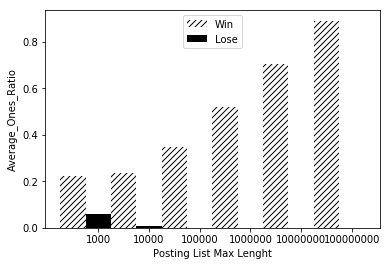

In [21]:
figure, ax = plt.subplots()
x = np.arange(6)

width = 0.5

ax.bar(x, average_Ones_Ratio_Hybrid_Co_bin_count_C_Li_wo1_EWAH_bitmap_Bytes_win, width, color='w', hatch='////', label='Win')
ax.bar(x + width, average_Ones_Ratio_Hybrid_Co_bin_count_C_Li_wo1_EWAH_bitmap_Bytes_lose, width , color='black', label='Lose')

plt.xticks(x + 0.5, map(lambda x: str(x), logBins))

ax.set_xlabel('Posting List Max Lenght')
ax.set_ylabel('Average_Ones_Ratio')
ax.legend(loc=9)

print "Win => C_Li_wo1_EWAH_bitmap_Bytes < C_Li_Bytes"
print "Lose => C_Li_wo1_EWAH_bitmap_Bytes > C_Li_Bytes\n"
print "Posting List Max Lenght\t\t Ones_Ratio_Hybrid_Co_Win\t\t Ones_Ratio_Hybrid_Co_lose"
for i, (win, lose) in enumerate(zip(average_Ones_Ratio_Hybrid_Co_bin_count_C_Li_wo1_EWAH_bitmap_Bytes_win, average_Ones_Ratio_Hybrid_Co_bin_count_C_Li_wo1_EWAH_bitmap_Bytes_lose)):
    print "%i \t\t\t\t %.2f \t\t\t\t %.2f" % (logBins[i], win, lose)

In [22]:
# [0,10^3), [10^3,10^4), [10^4,10^5), [10^5,10^6), [10^6,10^7), [10^7,10^8) #
logBins = np.logspace(3.0, 8, num=6, dtype=np.uint64)
bin_absolute_proportion_indexData = np.zeros(6, dtype=np.float64)
average_SS_Ratio_Hybrid_Co_indexData = np.zeros(6, dtype=np.float64)
average_SS_Ratio_Li_indexData = np.zeros(6, dtype=np.float64)

average_Li_Bytes_indexData = np.zeros(6, dtype=np.float64)
average_C_Li_Bytes_indexData = np.zeros(6, dtype=np.float64)
average_C_Li_wo1_EWAH_bitmap_Bytes_indexData = np.zeros(6, dtype=np.float64)

Li_Bytes_indexData = np.zeros(6, dtype=np.uint)
C_Li_Bytes_indexData = np.zeros(6, dtype=np.uint64)
C_Li_wo1_EWAH_bitmap_Bytes_indexData = np.zeros(6, dtype=np.uint64)

# max(uint64) = 8446744073709551615

for row in indexData.values:
    Li_Len = row[1]
    SS_Ratio_Hybrid_Co = row[20]
    SS_Ratio_Li = row[17]
    Li_Bytes = row[12]
    C_Li_Bytes = row[14]
    C_Li_wo1_EWAH_bitmap_Bytes = row[23]
    index = bisect.bisect_right(logBins, Li_Len)
    bin_absolute_proportion_indexData[index] += 1
    average_SS_Ratio_Hybrid_Co_indexData[index] += SS_Ratio_Hybrid_Co
    average_SS_Ratio_Li_indexData[index] += SS_Ratio_Li
    average_Li_Bytes_indexData[index] += Li_Bytes
    average_C_Li_Bytes_indexData[index] += C_Li_Bytes
    average_C_Li_wo1_EWAH_bitmap_Bytes_indexData[index] += C_Li_wo1_EWAH_bitmap_Bytes
    Li_Bytes_indexData[index] += Li_Bytes
    C_Li_Bytes_indexData[index] += C_Li_Bytes
    C_Li_wo1_EWAH_bitmap_Bytes_indexData[index] += C_Li_wo1_EWAH_bitmap_Bytes
    
average_SS_Ratio_Hybrid_Co_indexData = average_SS_Ratio_Hybrid_Co_indexData / bin_absolute_proportion_indexData
average_SS_Ratio_Li_indexData = average_SS_Ratio_Li_indexData / bin_absolute_proportion_indexData
average_Li_Bytes_indexData = average_Li_Bytes_indexData / bin_absolute_proportion_indexData
average_C_Li_Bytes_indexData = average_C_Li_Bytes_indexData / bin_absolute_proportion_indexData
average_C_Li_wo1_EWAH_bitmap_Bytes_indexData = average_C_Li_wo1_EWAH_bitmap_Bytes_indexData / bin_absolute_proportion_indexData

print bin_absolute_proportion_indexData

#print average_SS_Ratio_Hybrid_Co_indexData
#print average_SS_Ratio_Li_indexData
#print average_Li_Bytes_indexData
#print average_C_Li_Bytes_indexData
#print average_C_Li_wo1_EWAH_bitmap_Bytes_indexData
#print Li_Bytes_indexData
#print C_Li_Bytes_indexData
#print C_Li_wo1_EWAH_bitmap_Bytes_indexData

[  6.26007000e+05   1.36846000e+05   2.40830000e+04   6.47600000e+03
   1.10000000e+03   6.00000000e+00]


Posting List Max Lenght		 SS_Ratio_Hybrid_Co		 SS_Ratio_Li
1000 				 0.56 				 0.49
10000 				 0.67 				 0.62
100000 				 0.78 				 0.73
1000000 				 0.88 				 0.83
10000000 				 0.94 				 0.90
100000000 				 0.98 				 0.94


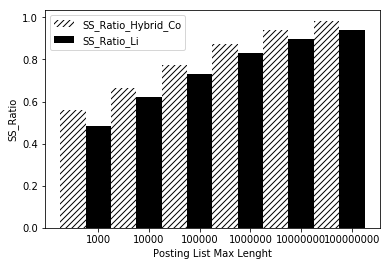

In [23]:
figure, ax = plt.subplots()
x = np.arange(6)

width = 0.5

ax.bar(x, average_SS_Ratio_Hybrid_Co_indexData, width, color='w', hatch='////', label='SS_Ratio_Hybrid_Co')
ax.bar(x + width, average_SS_Ratio_Li_indexData, width , color='black', label='SS_Ratio_Li')

plt.xticks(x + 0.5, map(lambda x: str(x), logBins))

ax.set_xlabel('Posting List Max Lenght')
ax.set_ylabel('SS_Ratio')
ax.legend(loc=2)

print "Posting List Max Lenght\t\t SS_Ratio_Hybrid_Co\t\t SS_Ratio_Li"
for i, (a, b) in enumerate(zip(average_SS_Ratio_Hybrid_Co_indexData, average_SS_Ratio_Li_indexData)):
    print "%i \t\t\t\t %.2f \t\t\t\t %.2f" % (logBins[i], a, b)

PLML		 Li_Bytes		C_Li_Bytes 		C_Li_wo1_EWAH_bitmap_Bytes
1000 , 1148 , 571 , 493
10000 , 11144 , 4052 , 3531
100000 , 120662 , 30189 , 24780
1000000 , 1292065 , 185123 , 129671
10000000 , 8954601 , 844618 , 447376
100000000 , 44900007 , 2654990 , 708081


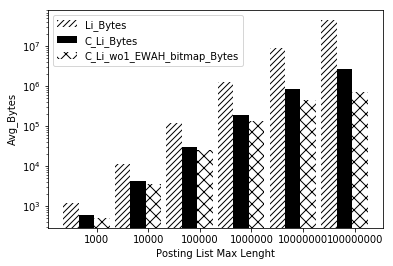

In [24]:
figure, ax = plt.subplots()
x = np.arange(6)

width = 0.30

ax.bar(x, average_Li_Bytes_indexData, width, color='w', hatch='////', label='Li_Bytes')
ax.bar(x + width, average_C_Li_Bytes_indexData, width , color='black', label='C_Li_Bytes')
ax.bar(x + width * 2, average_C_Li_wo1_EWAH_bitmap_Bytes_indexData, width , color='w',  hatch='xx', label='C_Li_wo1_EWAH_bitmap_Bytes')

plt.xticks(x + 0.5, map(lambda x: str(x), logBins))

ax.set_xlabel('Posting List Max Lenght')
ax.set_ylabel('Avg_Bytes')
ax.set_yscale('log')
ax.legend(loc=2)

print "PLML\t\t Li_Bytes\t\tC_Li_Bytes \t\tC_Li_wo1_EWAH_bitmap_Bytes"
for i, (a, b, c) in enumerate(zip(average_Li_Bytes_indexData, average_C_Li_Bytes_indexData, average_C_Li_wo1_EWAH_bitmap_Bytes_indexData)):
    print "%i , %i , %i , %i" % (logBins[i], a, b, c)

PLML		 Li_Bytes		C_Li_Bytes 		C_Li_wo1_EWAH_bitmap_Bytes
1000 , 719008432 , 357689864 , 309085478
10000 , 1525074024 , 554504992 , 483271222
100000 , 2905914760 , 727060960 , 596798002
1000000 , 8367417032 , 1198860212 , 839755440
10000000 , 9850061204 , 929079808 , 492114618
100000000 , 269400044 , 15929940 , 4248490


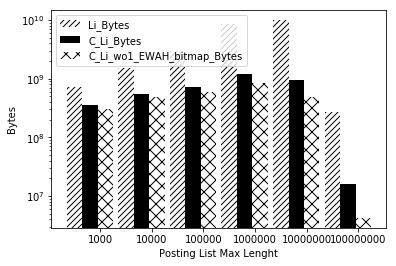

In [25]:
figure, ax = plt.subplots()
x = np.arange(6)

width = 0.30

ax.bar(x, Li_Bytes_indexData, width, color='w', hatch='////', label='Li_Bytes')
ax.bar(x + width, C_Li_Bytes_indexData, width , color='black', label='C_Li_Bytes')
ax.bar(x + width * 2, C_Li_wo1_EWAH_bitmap_Bytes_indexData, width , color='w',  hatch='xx', label='C_Li_wo1_EWAH_bitmap_Bytes')

plt.xticks(x + 0.5, map(lambda x: str(x), logBins))

ax.set_xlabel('Posting List Max Lenght')
ax.set_ylabel('Bytes')
ax.set_yscale('log')
ax.legend(loc=2)

print "PLML\t\t Li_Bytes\t\tC_Li_Bytes \t\tC_Li_wo1_EWAH_bitmap_Bytes"
for i, (a, b, c) in enumerate(zip(Li_Bytes_indexData, C_Li_Bytes_indexData, C_Li_wo1_EWAH_bitmap_Bytes_indexData)):
    print "%i , %i , %i , %i" % (logBins[i], a, b, c)

In [26]:
print "PLML\t\t # of Posting Lists per Bin"
for i, a in enumerate(bin_absolute_proportion_indexData):
    print "%i , %.2f" % (logBins[i], a)

PLML		 # of Posting Lists per Bin
1000 , 626007.00
10000 , 136846.00
100000 , 24083.00
1000000 , 6476.00
10000000 , 1100.00
100000000 , 6.00
